# **Construindo um Modelo com Tensorflow -  🐶 🐱!**

**Problema: uma imagem, dizer se é um dog ou um cat.**

Computer Vision; Deep Learning; Machine Learning; Artificial Inteligence! Nada disso faz sentido sem dados, muitos dados (Big Data! 🚀). Para isso, teremos:

* **Treinamento**: 25.000 imagens nomeadas: 12.500 de dogs e 12.500 de cats.
* **Teste**: 1.000 imagens de dogs e cats.

Usa-se os dados de treino para treinar o algoritmo e então criar o modelo preditivo. Usa-se os dados de teste para confirmar o desempenho do modelo preditivo já treinado, ou seja, apresenta-se ao modelo preditivo dados que ele não viu durante o treinamento, a fim de garantir que ele seja capaz de fazer previsões.

Por fim, o modelo de duas camadas de convolução seguidas de pooling, a camada de flattening, e as camadas totalmente conectadas (Dense), com a função de ativação sigmoid para a saída binária.

**Não há mágica. Há matemática!** 🧙

Fonte de dados

O Kaggle oferece diversos datasets públicos que podem ser usados para você desenvolver seus projetos e incluir no seu portfólio, uma excelente forma de demonstrar suas habilidades em Data Science e Machine Learning. Usaremos como fonte de dados, o famoso [dataset Dogs and Cats](https://www.kaggle.com/c/dogs-vs-cats/data)

**Carregando os dados de Treino e Teste**



In [3]:
from google.colab import files
import zipfile
import os

files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Definindo permissões corretas
!chmod 600 /root/.kaggle/kaggle.json

# Instalando o pacote Kaggle
!pip install kaggle

!kaggle competitions download -c dogs-vs-cats

with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats')

with zipfile.ZipFile('dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats/train')  # Extrai para a pasta 'train'

# Extrair o arquivo test1.zip (se encontrado)
with zipfile.ZipFile('dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats/test')  # Extrai para a pasta 'test'


Saving kaggle.json to kaggle.json


In [54]:
import os
import shutil

# Criar diretórios se não existirem
os.makedirs('/content/dogsvscats/train/cats', exist_ok=True)
os.makedirs('/content/dogsvscats/train/dogs', exist_ok=True)

# Caminho para a pasta onde todas as imagens estão juntas
source_folder = "/content/dogs-vs-cats/train/train"

# Mover cada imagem para a pasta correspondente
for filename in os.listdir(source_folder):
    if "cat" in filename.lower():
        shutil.move(os.path.join(source_folder, filename), "/content/dogsvscats/train/cats/")
    elif "dog" in filename.lower():
        shutil.move(os.path.join(source_folder, filename), "/content/dogsvscats/train/dogs/")

In [42]:
# Criar diretórios se não existirem
os.makedirs('/content/dogsvscats/test', exist_ok=True)

# Caminho para a pasta onde todas as imagens estão juntas
source_folder = "/content/dogs-vs-cats/test/test1"

# Mover cada imagem para a pasta correspondente
for filename in os.listdir(source_folder):
    shutil.move(os.path.join(source_folder, filename), "/content/dogsvscats/test")

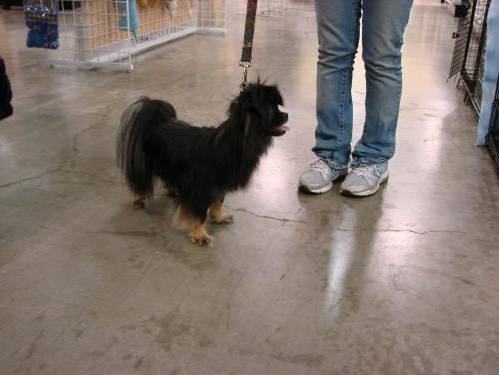

In [11]:

# Do dataset de treino, carregue uma imagem de cachorro
from IPython.display import Image
Image(filename='/content/dogsvscats/train/dogs/dog.1000.jpg')

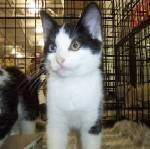

In [12]:
# Do dataset de treino, carregue uma imagem de gato
from IPython.display import Image
Image(filename='/content/dogsvscats/train/cats/cat.1000.jpg')


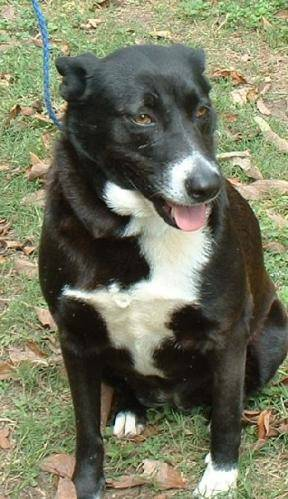

In [43]:
# Do dataset de teste, carregue uma imagem de gato ou de cachorro
from IPython.display import Image
Image(filename='/content/dogsvscats/test/1000.jpg')

**Construindo a Rede Neural Convolucional**

O Keras é uma biblioteca do TensorFlow.



In [34]:
import tensorflow as tf
import keras as K
# Importar K e suas funções necessárias
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [21]:
# Inicializando a rede neural
classifier = Sequential()

# Primeira Camada de Convolução
classifier.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda Camada de Convolução
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira Camada de Convolução
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Quarta Camada de Convolução (nova camada adicionada)
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
classifier.add(Flatten())

# Full Connection
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.5))  # Regularização

# Camada de Saída
classifier.add(Dense(units=1, activation='sigmoid'))

# Compilação
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Pré-processamento**

Fazer pré-processamento nos dados, em nosso caso as imagens.

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar o objeto com as regras de pré-processamento
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2 )

test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
# Pré-processamento das imagens de treino
training_set = train_datagen.flow_from_directory('/content/dogsvscats/train',
                                                 target_size=(256, 256),
                                                 batch_size=64,
                                                 class_mode = 'binary',
                                                 subset='training')

Found 20000 images belonging to 2 classes.


In [48]:
# Pré-processamento das imagens de teste
test_set = test_datagen.flow_from_directory('/content/dogsvscats/test',
                                            target_size=(256, 256),
                                            batch_size=64,
                                            class_mode='binary',
                                            subset='validation')

Found 0 images belonging to 0 classes.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

**Treinamento do Modelo**

In [32]:
# Executando o treinamento
classifier.fit(
    training_set,
    steps_per_epoch=625,
    callbacks=[early_stopping],  # Ajustado com base no número total de imagens e batch size
    epochs=10)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 519ms/step - accuracy: 0.6820 - loss: 0.5997
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 528ms/step - accuracy: 0.7631 - loss: 0.4958
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 374s 515ms/step - accuracy: 0.7965 - loss: 0.4433
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 518ms/step - accuracy: 0.8161 - loss: 0.4070
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 387s 526ms/step - accuracy: 0.8342 - loss: 0.3746
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 379s 521ms/step - accuracy: 0.8472 - loss: 0.3550
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 384s 525ms/step - accuracy: 0.8534 - loss: 0.3343
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 517ms/step - accuracy: 0.8632 - loss: 0.3168
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 334s 533ms/step - accuracy: 0.8642 - loss: 0.3087
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 417s 590ms/step - accuracy: 0.8780 - loss: 0.2879


Treinamento concluído com sucesso! 💪 Observe se ao final de cada época a acurácia aumenta.


**Teste do Modelo**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Previsão: Gato.
Acurácia: 98.54 %.


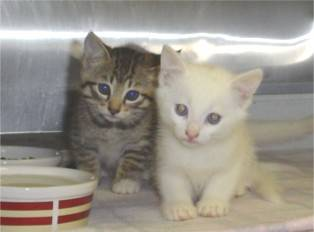

In [53]:
import numpy as np
from keras.preprocessing import image

# Carregando a imagem de teste
test_image = image.load_img('/content/dogsvscats/test/1500.jpg', target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalizar a imagem

# Fazendo a previsão usando o modelo classifier
result = classifier.predict(test_image)
class_indices = training_set.class_indices

if result[0][0] >= 0.5:
    prediction = 'Cachorro.'
    accuracy = round(result[0][0] * 100, 2)  # A saída de previsão é uma probabilidade entre 0 e 1
else:
    prediction = 'Gato.'
    accuracy = round((1 - result[0][0]) * 100, 2)  # A saída de previsão é uma probabilidade entre 0 e 1

# Exibindo a previsão e a acurácia
print("Previsão:", prediction)
print("Acurácia:", accuracy, "%.")

# Exibindo a imagem
Image(filename='/content/dogsvscats/test/1500.jpg')


Como as imagens de teste não possuem rótulos, não consegui fazer a validação dos dados de teste pra plotar a matriz de confusão.